In [143]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [144]:
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import requests
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
import zipfile
import pathlib

import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import datetime

In [145]:
os.environ['TF_CPP_MIN_LEVEL'] = '0'
np.set_printoptions(precision=3, suppress=True)

In [146]:

test_data_dir = '../data/Test'
appleDirectory = '../data/Train'
data_dir = pathlib.Path(appleDirectory)
edgeFiles = list()

for filename in os.listdir(appleDirectory):
    imgAppleDirectory = os.path.join(appleDirectory, filename)
    edgeFiles.append(imgAppleDirectory)
    # print(edgeFiles)

In [147]:
edgeFiles = [img for img in edgeFiles if ".jpg" in img]
# print(type(edgeFiles))
# print(edgeFiles[0])

In [148]:
batch_size = 32
img_height = 360
img_width = 360

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 382 files belonging to 4 classes.
Using 306 files for training.


In [149]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 382 files belonging to 4 classes.
Using 76 files for validation.


In [150]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 120 files belonging to 4 classes.


In [151]:
class_names = train_ds.class_names
test_label = test_ds.class_names

In [152]:
# augmentation toegevoegen
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
  layers.RandomRotation(45.5),
])

In [153]:
# augmentation toegevoegen
image, label = next(iter(train_ds))

In [154]:
# augmentation toegevoegen
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

In [155]:

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(16):
#         augmented_image = data_augmentation(images, training = True)
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(augmented_image[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

In [156]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(rate=0.2 ),  
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [157]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [158]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [159]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 360, 360, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 360, 360, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 360, 360, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 180, 180, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                

In [160]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback])


Epoch 1/15
10/10 [==============================] - 19s 2s/step - loss: 2.1379 - accuracy: 0.2549 - val_loss: 1.3741 - val_accuracy: 0.2368
Epoch 2/15
10/10 [==============================] - 16s 2s/step - loss: 1.3322 - accuracy: 0.3431 - val_loss: 1.2921 - val_accuracy: 0.2368
Epoch 3/15
10/10 [==============================] - 17s 2s/step - loss: 1.2038 - accuracy: 0.4477 - val_loss: 1.0888 - val_accuracy: 0.4605
Epoch 4/15
10/10 [==============================] - 17s 2s/step - loss: 1.0616 - accuracy: 0.5621 - val_loss: 1.0138 - val_accuracy: 0.5263
Epoch 5/15
10/10 [==============================] - 17s 2s/step - loss: 1.0363 - accuracy: 0.5850 - val_loss: 0.9343 - val_accuracy: 0.5526
Epoch 6/15
10/10 [==============================] - 16s 2s/step - loss: 0.9568 - accuracy: 0.6242 - val_loss: 0.8918 - val_accuracy: 0.5921
Epoch 7/15
10/10 [==============================] - 16s 2s/step - loss: 0.9017 - accuracy: 0.6438 - val_loss: 0.9665 - val_accuracy: 0.5921
Epoch 8/15
10/10 [==

In [161]:
# Tensorboard
log_dir = "logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [162]:
from keras.models import load_model

model.save('saved_models/appleModel_06.h5')

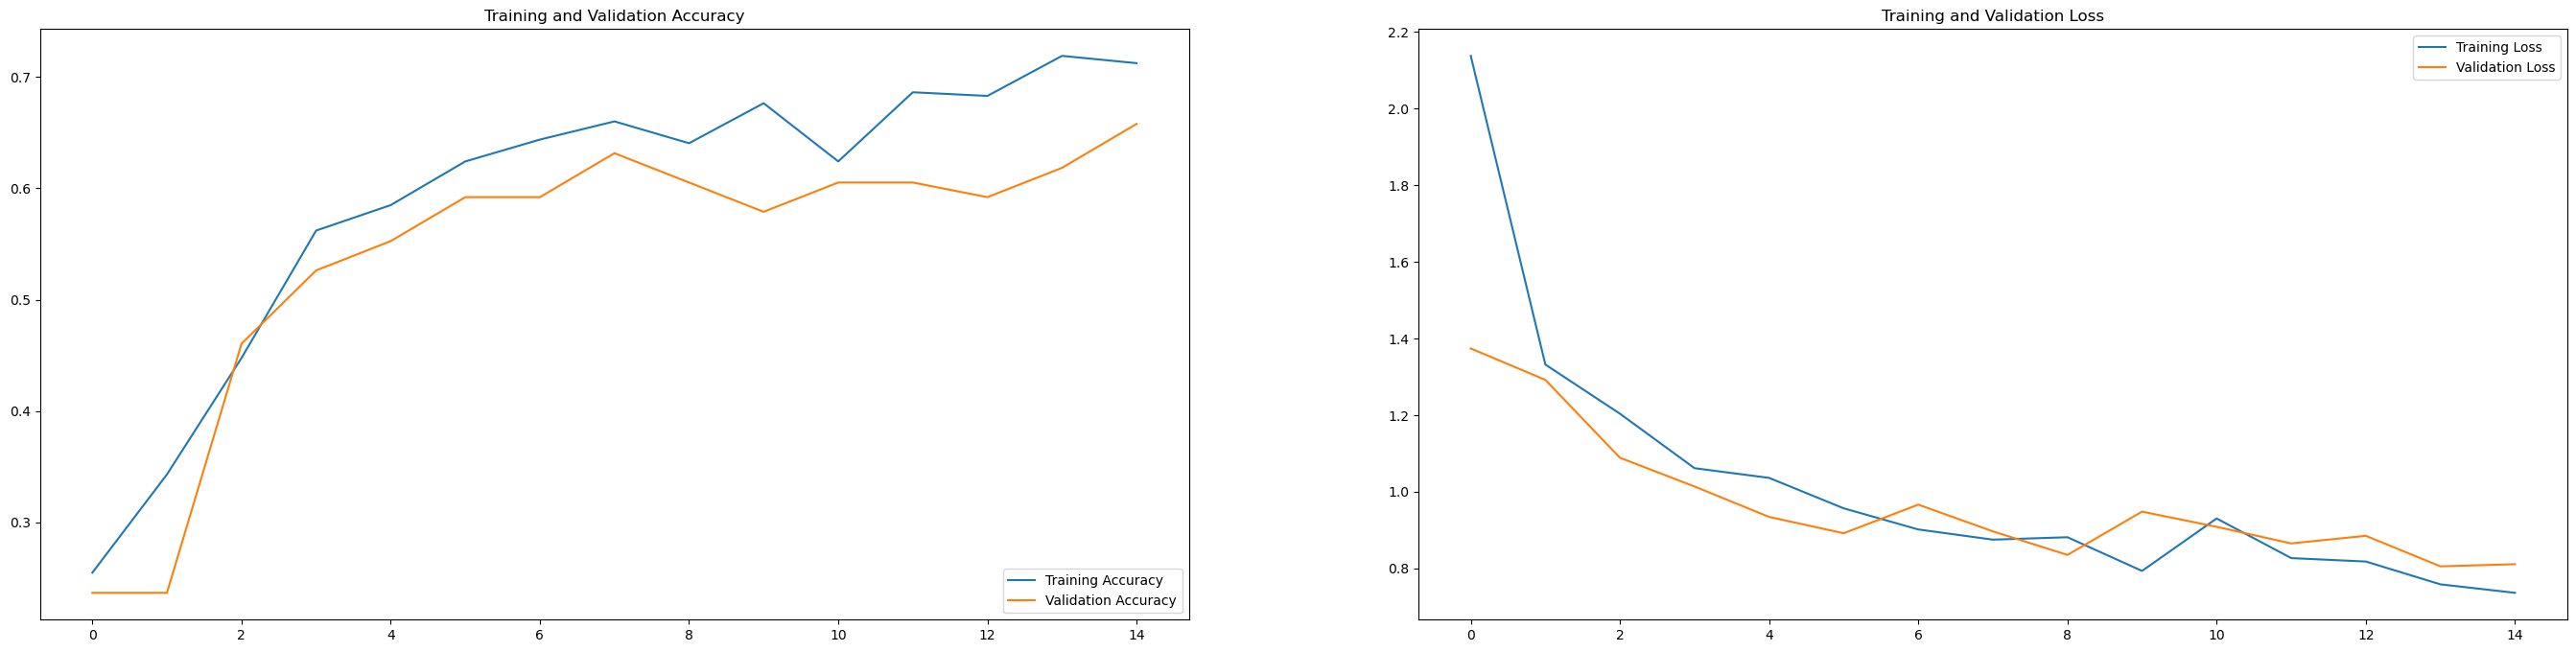

In [163]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(34, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [164]:
plt.savefig('saved_models/appleModel_06.png')

<Figure size 640x480 with 0 Axes>

4/4 [==============================] - 2s 435ms/step


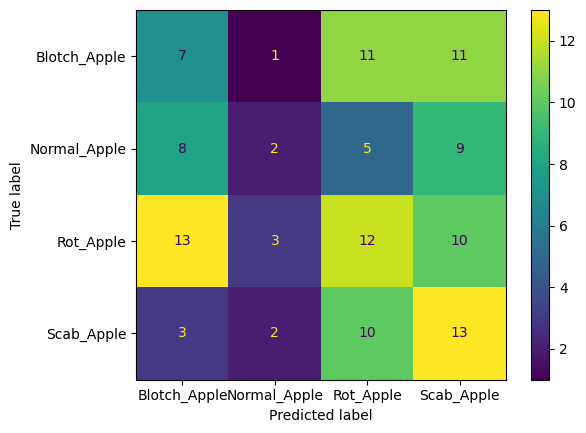

In [165]:
# confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

batchPredictions = model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# confusion_matrix(predicted_categories, true_categories)

confusion_matrix = confusion_matrix(true_categories, predicted_categories)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple'])



cm_display.plot()

plt.show()


In [166]:
%tensorboard --logdir logs/



Reusing TensorBoard on port 6011 (pid 43756), started 18:38:42 ago. (Use '!kill 43756' to kill it.)